In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u"]#,"g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

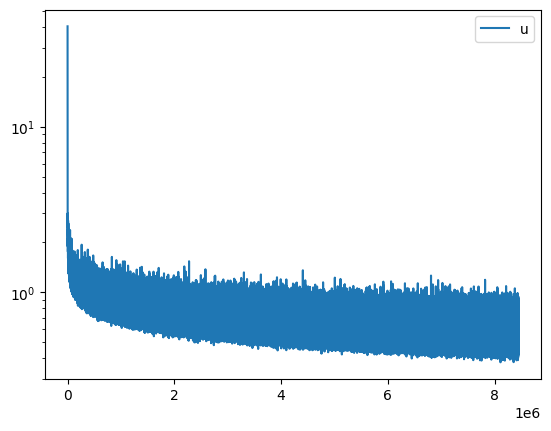

In [3]:
i = 0
for x in loss_bands:
    plt.plot(x, label=bands[i])
    i+=1

plt.yscale("log")
plt.legend()

0.5180214643478394


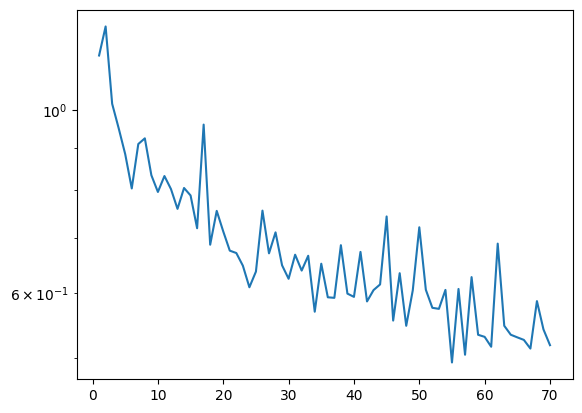

In [4]:
i = 0
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

def cut(z):
    return 10**(z+4)

band = 0

z = sps_params_train[:, 0]
mass = sps_params_train[:, -1]
mag = phot_train[:, band]

inds = np.where(mass > cut(z))[0]

sps_params_train = sps_params_train[inds]
phot_train = phot_train[inds]


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


971681
total outliers:  55.53458388092388


(1e-32, 1e-23)

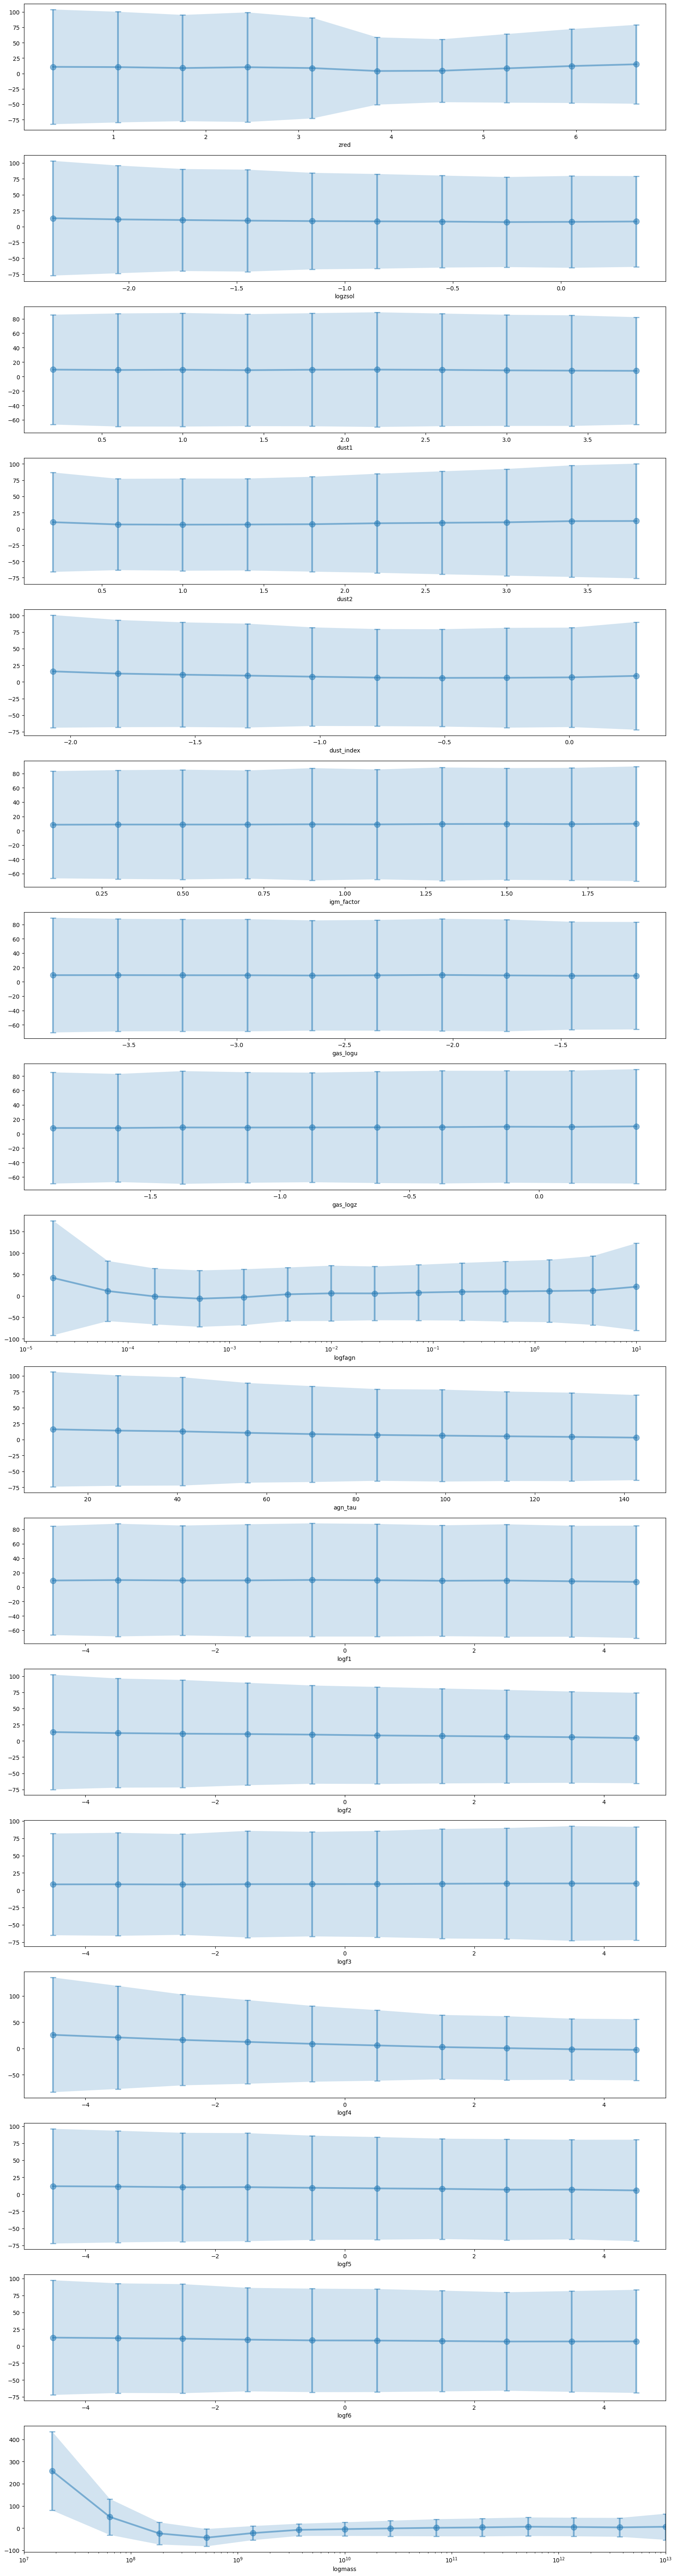

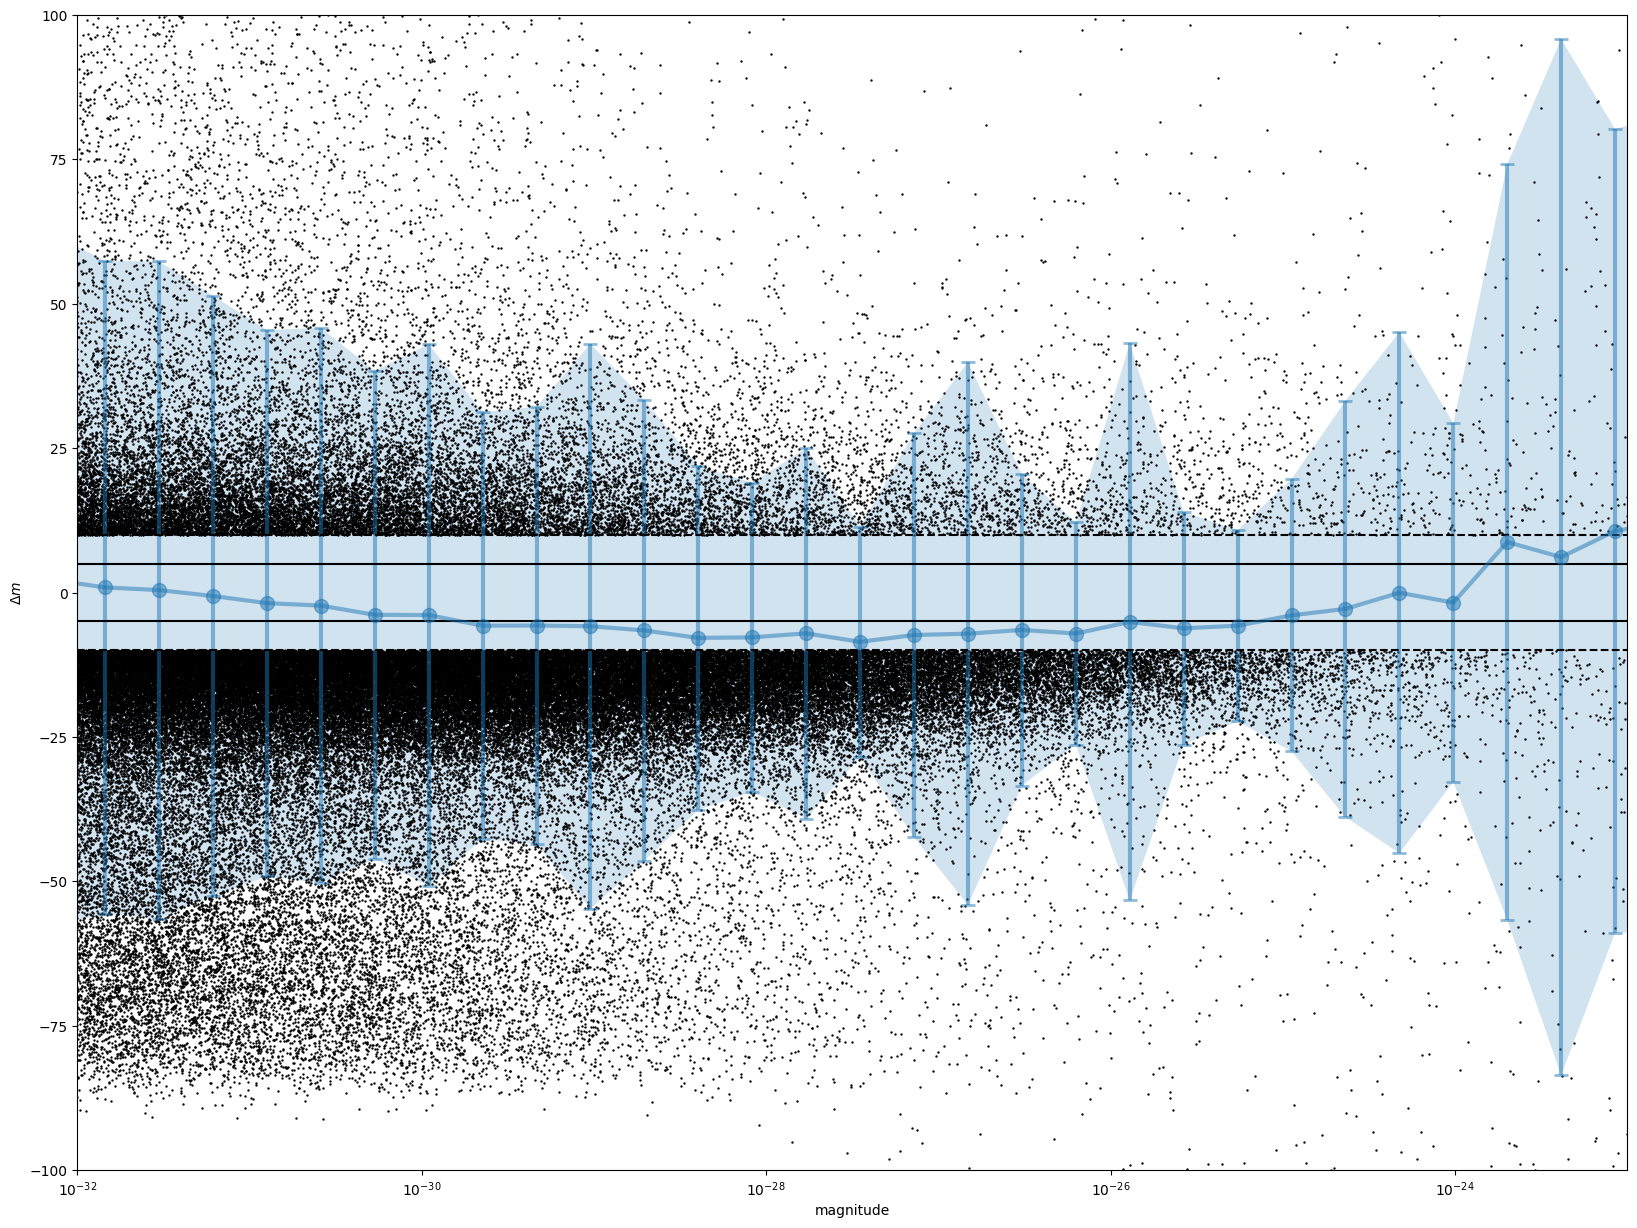

In [7]:
def mab_to_flux(mag):
    return 3.631e-20*10**(-(mag/2.5))


#mag_cut_upper = 30
#mag_cut_lower = 10
#inds = np.where((phot_train[:, 0] < mag_cut_upper) & (phot_train[:, 0] > mag_cut_lower))[0] #UBAND ONLY!!!!!!!!!!!!!!!!!!!!!!

#phot_train = phot_train[inds]
#sps_params_train = sps_params_train[inds, :]

nsamples=1200000
band = 0
#z_train = sps_params_train[:nsamples, 0]
#mass_train = sps_params_train[:nsamples, -1]
#mag = phot_train[:nsamples, band]

#inds = np.where(mass_train > cut(z_train))[0]

#sps_params_train = sps_params_train[inds]
#phot_train = phot_train[inds]

y_bound = 10.0
sps_params = sps_params_train[:nsamples, :]
m_mimic = mab_to_flux(model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0]))
print(sps_params.shape[0])
m_true = mab_to_flux(phot_train[:nsamples, :])
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = ((m_mimic[:, j]-m_true[:, j])/(m_true[:, j]))*100
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', np.logspace(-50, -19, 100))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', np.logspace(-50, -19, 100))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')
axes2.set_xscale('log')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

axes2.axhline(y=y_bound/2, color='k', linestyle='-')
axes2.axhline(y=-y_bound/2, color='k', linestyle='-')

#axes2.axhline(y=1, color='k', linestyle='-')
#axes2.axhline(y=-1, color='k', linestyle='-')

#axes2.axvline(x=10, color='k', linestyle='--')
#axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-100, 100)

axes2.set_xlim(1e-32, 1e-23)


In [8]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

def cut(z):
    return 10**(z+4)

band = 0

z = sps_params_train[:, 0]
mass = sps_params_train[:, -1]
mag = phot_train[:, band]

inds = np.where(mass > cut(z))[0]

sps_params_train = sps_params_train[inds]
phot_train = phot_train[inds]

total outliers:  17.740081364151404


(-10.0, 4.0)

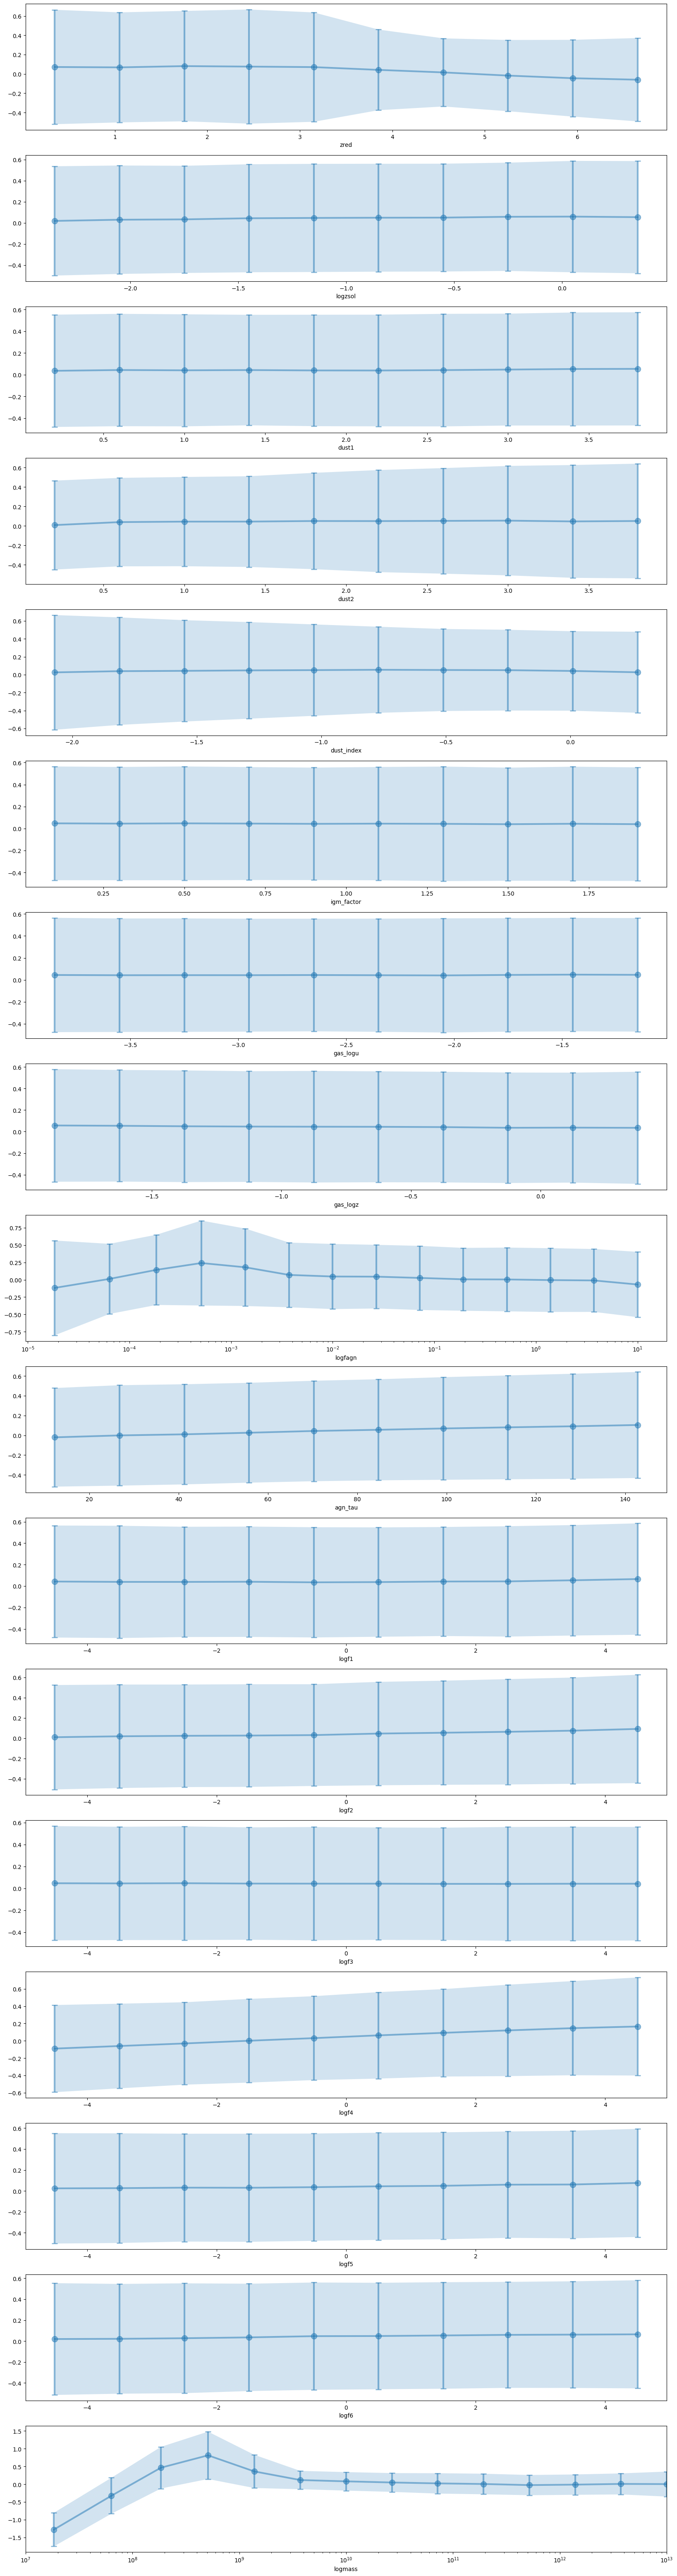

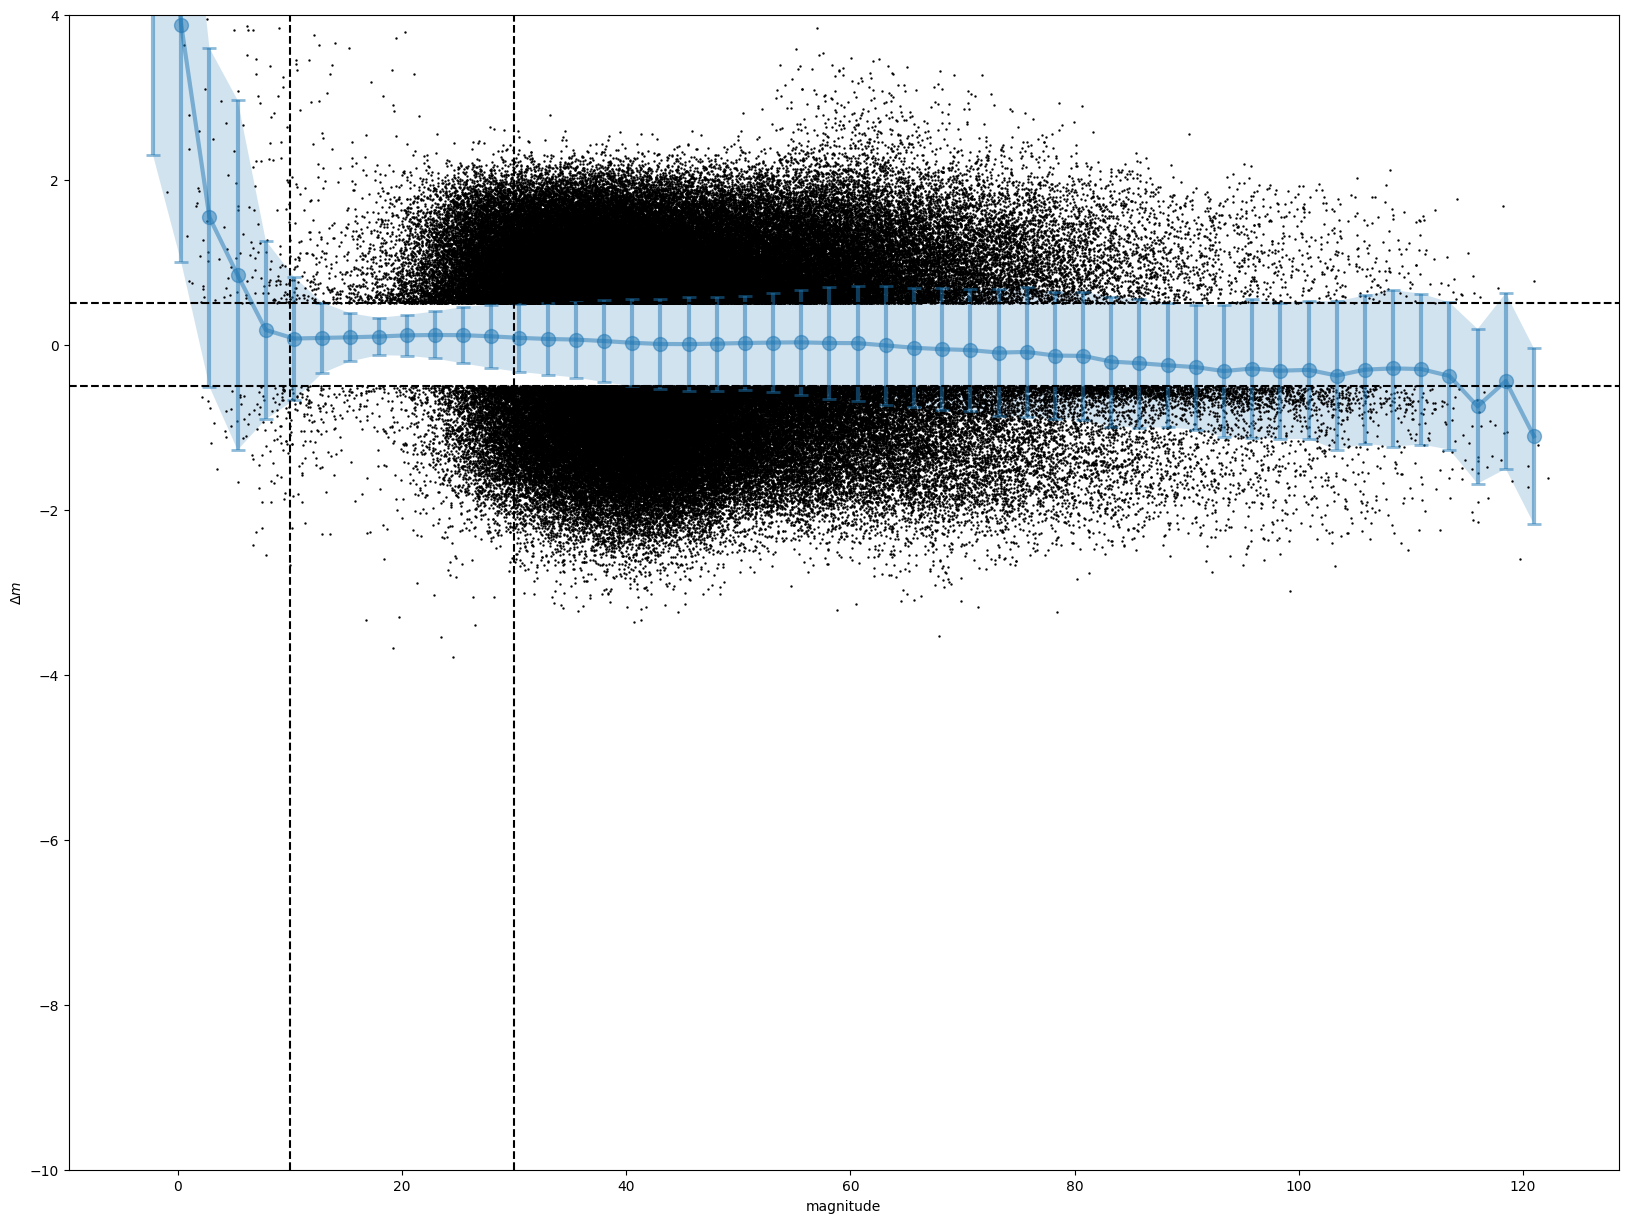

In [9]:
nsamples=1200000
y_bound = 0.5
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0])
m_true = phot_train[:nsamples, :]
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', 50)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', 50)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=0.1, color='k', linestyle='-')
#axes2.axhline(y=0.1, color='k', linestyle='-')

axes2.axvline(x=10, color='k', linestyle='--')
axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-10, 4)

#axes2.set_xlim(0, 40)


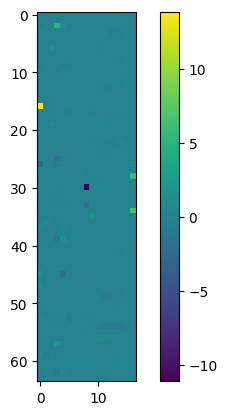

In [21]:
weights = model._models[0].W
biases = model._models[0].b
a = model._models[0].alphas
b = model._models[0].betas

layer = 0

weights[layer].shape

plt.imshow(np.transpose(weights[layer]))
plt.colorbar()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  2., 18., 32.,
        13., 22., 27.,  0.,  1.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.00342846, -6.75675821, -6.51008797, -6.26341772, -6.01674747,
        -5.77007675, -5.52340651, -5.27673626, -5.03006601, -4.78339577,
        -4.53672552, -4.29005527, -4.04338503, -3.79671454, -3.5500443 ,
        -3.30337405, -3.05670381, -2.81003356, -2.56336308, -2.31669283,
        -2.07002258, -1.82335234, -1.57668197, -1.33001173, -1.08334136,
        -0.83667111, -0.59000081, -0.34333053, -0.09666023,  0.15001006,
         0.39668036,  0.64335066,  0.89002097,  1.13669121,  1.38336158,
         1.63003182,  1.87670207,  2.12337232,  2.3700428 ,  2.61671305,
         2.86338329,  3.11005354,  3.35672379,  3.60339427,  3.85006452,
         4.096735  ,  4.34340525,  4.59007549,  4.83674574,

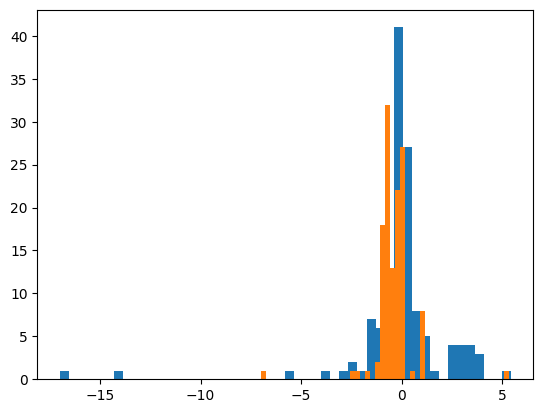

In [11]:
layer = 1

plt.hist(a[layer].numpy(), bins=50)
plt.hist(b[layer].numpy(), bins=50)

#plt.hist(a[layer])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  5., 11.,  8., 18.,  3.,
         2.,  3.,  2.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,  2.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-5.11827803, -4.90881443, -4.69935036, -4.48988676, -4.28042269,
        -4.07095909, -3.86149502, -3.65203118, -3.44256735, -3.23310351,
        -3.02363968, -2.81417584, -2.60471201, -2.39524841, -2.18578458,
        -1.97632062, -1.76685679, -1.55739295, -1.34792912, -1.1384654 ,
        -0.92900151, -0.71953768, -0.5100739 , -0.30061004, -0.09114622,
         0.1183176 ,  0.32778144,  0.53724527,  0.74670911,  0.95617288,
         1.16563678,  1.37510061,  1.58456433,  1.79402816,  2.00349212,
         2.21295595,  2.42241979,  2.63188362,  2.84134722,  3.05081105,
         3.26027489,  3.46973872,  3.67920256,  3.88866639,  4.09813023,
         4.3075943 ,  4.5170579 ,  4.72652197,  4.93598557,

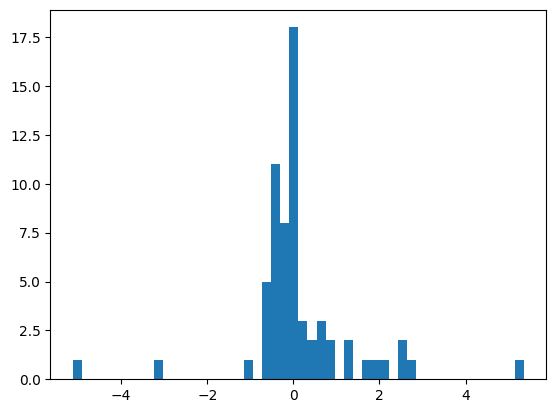

In [12]:
layer = 0

biases[layer].shape
plt.hist(biases[layer].numpy(), bins=50)